In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
image_dir = Path(r"C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHETIC")

In [4]:
filepaths = list(image_dir.glob(r'*/*.JPG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
image_df

,Filepath,Label
0,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,brain_tumors.jpg
1,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,brain_tumors.jpg
2,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,brain_tumors.jpg
3,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,brain_tumors.jpg
4,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,brain_tumors.jpg
...,...,...
39995,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,kidney_tumors.jpg
39996,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,kidney_tumors.jpg
39997,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,kidney_tumors.jpg
39998,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,kidney_tumors.jpg


In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.80, shuffle=True, random_state=1)

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,
                                                                  width_shift_range=0.2,
                                                                  height_shift_range=0.2,
                                                                  validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [8]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                   x_col='Filepath',
                                                   y_col='Label',
                                                   target_size=(64, 64),
                                                   color_mode='rgb',
                                                   class_mode='binary',
                                                   batch_size=32,
                                                   shuffle=True,
                                                   seed=42,
                                                   subset='training')

val_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                 x_col='Filepath',
                                                 y_col='Label',
                                                 target_size=(64, 64),
                                                 color_mode='rgb',
                                                 class_mode='binary',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=42,
                                                 subset='validation')

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='Filepath',
                                                 y_col='Label',
                                                 target_size=(64, 64),
                                                 color_mode='rgb',
                                                 class_mode='binary',
                                                 batch_size=32,
                                                 shuffle=False)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Dropout, Flatten
from tensorflow.keras.layers import Dropout

from keras.applications.vgg19 import VGG19
#from keras.applications.vgg16 import preprocess_input


vgg = VGG19(input_shape= (64, 64, 3), weights='imagenet', include_top=False)
vgg.trainable = False



80134624/80134624 [==============================] - 11s 0us/step


In [10]:
model = keras.Sequential([
    vgg,
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

In [11]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20089985 (76.64 MB)
Trainable params: 6560

In [13]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.functional.Functional object at 0x000002796F508510> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x000002796ED1A3D0> True
<keras.src.layers.regularization.dropout.Dropout object at 0x0000027969B01F50> True
<keras.src.layers.core.dense.Dense object at 0x000002796F564050> True
<keras.src.layers.regularization.dropout.Dropout object at 0x000002796EC4EAD0> True
<keras.src.layers.core.dense.Dense object at 0x000002796F52BD90> True


In [14]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/50


800/800 [==============================] - 276s 342ms/step - loss: 0.1227 - accuracy: 0.9510 - val_loss: 0.0384 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 2/50
800/800 [==============================] - 292s 365ms/step - loss: 0.0596 - accuracy: 0.9782 - val_loss: 0.0410 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 3/50
800/800 [==============================] - 293s 366ms/step - loss: 0.0515 - accuracy: 0.9801 - val_loss: 0.0236 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 4/50
800/800 [==============================] - 292s 364ms/step - loss: 0.0442 - accuracy: 0.9832 - val_loss: 0.0187 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 5/50
800/800 [==============================] - 293s 366ms/step - loss: 0.0397 - accuracy: 0.9854 - val_loss: 0.0209 - val_accuracy: 0.9945 - lr: 0.0010
Epoch 6/50
800/800 [==============================] - 293s 366ms/step - loss: 0.0358 - accuracy: 0.9859 - val_loss: 0.0162 - val_accuracy: 0.9945 - lr: 0.0010
Epoch 7/50
800/800 [========================

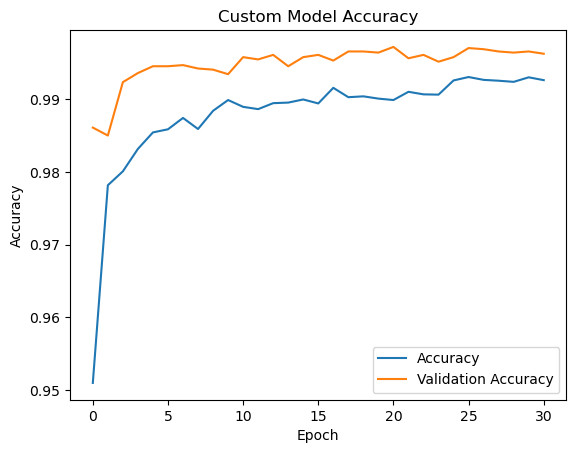

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Custom Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation Accuracy', 'loss', 'Validation Loss'])
plt.show()

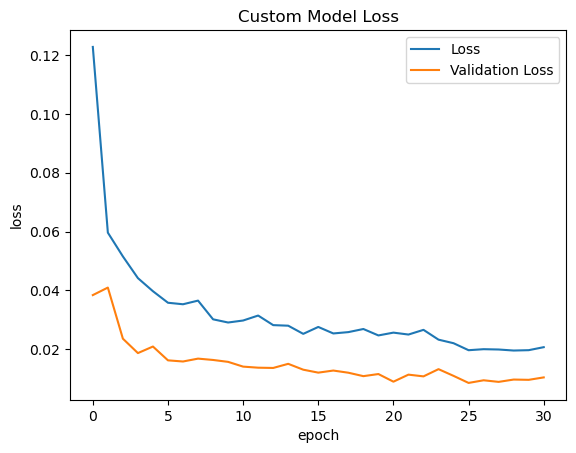

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Custom Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [17]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00584
Test Accuracy: 99.76%


250/250 [==============================] - 42s 165ms/step


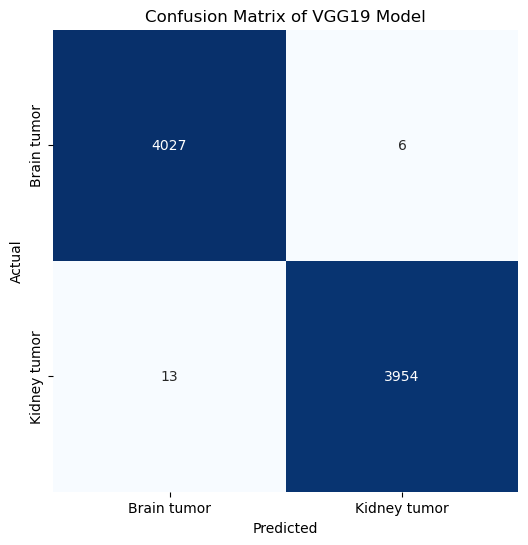

Classification Report:
----------------------
               precision    recall  f1-score   support

 Brain tumor       1.00      1.00      1.00      4033
Kidney tumor       1.00      1.00      1.00      3967

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [18]:
predictions = (model.predict(test_images) >= 0.5).astype(int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["Brain tumor", "Kidney tumor"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["Brain tumor", "Kidney tumor"])
plt.yticks(ticks=[0.5, 1.5], labels=["Brain tumor", "Kidney tumor"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of VGG19 Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)

250/250 [==============================] - 41s 165ms/step
AUC ROC: 0.99999


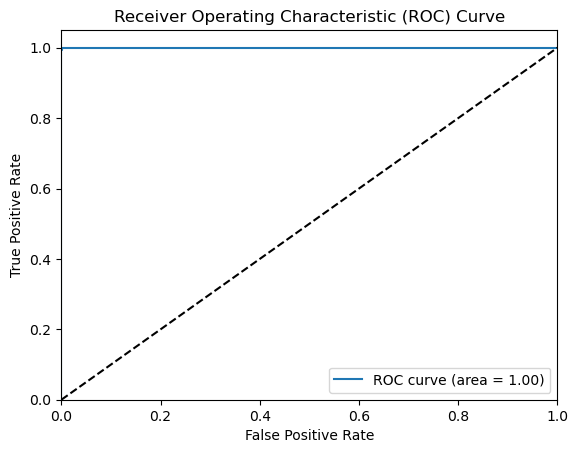

In [19]:
# Obtain predicted probabilities
from sklearn.metrics import roc_auc_score, roc_curve

predicted_probabilities = model.predict(test_images)

# Compute AUC ROC
auc_roc = roc_auc_score(test_images.labels, predicted_probabilities)

print("AUC ROC: {:.5f}".format(auc_roc))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_images.labels, predicted_probabilities)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [19]:
# save the model to a file
model.save('VGG19- ACC vs Kidney tumor .h5')